Pour qu'il n'ai pas de problème lors des importations

In [1]:
# import sys
# sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon')

# Importation

In [2]:
from fastmri.data import transforms as T
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.autograd import Variable

from utils.vcr import virtual_coil_reconstruction
from utils.data_transform import load_and_transform

from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.models.varnet import VarNet 


# Download & Transform

In [3]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"

# Renvoie un Tensor Pytorch 
kspace_multicoil = load_and_transform(file_path)
images_multicoil = torch.fft.fftshift(torch.fft.ifft2(kspace_multicoil))

# Renvoie une image Single Coil
image = virtual_coil_reconstruction(images_multicoil)

# Coil = 1 
image = image.unsqueeze(1)

# Kspace of the new image
kspace = torch.fft.fft2(image)

print(kspace_multicoil.shape)
print(images_multicoil.shape)
print(image.shape)
print(kspace.shape)

torch.Size([16, 16, 640, 320])
torch.Size([16, 16, 640, 320])
torch.Size([16, 1, 640, 320])
torch.Size([16, 1, 640, 320])


Show all the batch

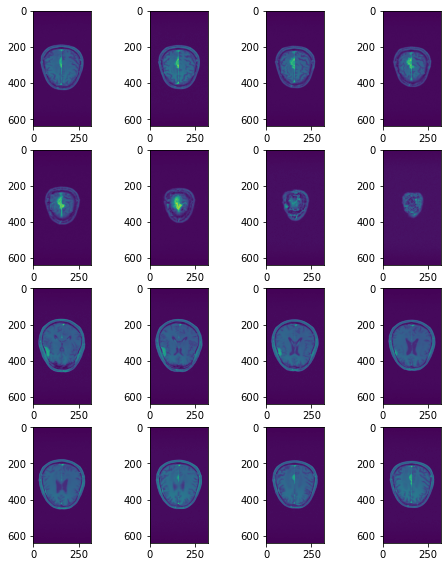

In [4]:
plt.rcParams['figure.figsize'] = (16, 16)

# # Show image (abs(image))
plt.figure(figsize=(8,20))
for i in range(kspace.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(np.abs(image[i, 0, :,:]))

# # Show image's phase (angle(image))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.angle(image[i, 0, :,:]))

# # Show kspace (abs(kspace))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(kspace[i,0, :,:]))


# Mask application

In [5]:
#  Parametres
mask_type = "random"
center_fractions = [0.08]
accelerations = [4]

# Function de Mask
mask_func = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

# Reajustement shape pour bien avoir un mask en fonction de l'Ordonnée
kspace = kspace.unsqueeze(-1)

# Application
zero_filled_list, mask_list = [], []
for batch in range (kspace.shape[0]) :
    mask, _ = mask_func(kspace.shape)
    masked_kspace = kspace[batch] * mask
    zero_filled =torch.fft.ifftn(masked_kspace)
    zero_filled_list.append(zero_filled)
    mask_list.append(mask)

zero_filled = torch.cat(zero_filled_list)
mask = torch.cat(mask_list)

# Pour l'entrainement
target = image.abs().unsqueeze(1)

print("kspace : ",kspace.shape)
print("all masks: ",mask.shape)
print("zero_filled's kspace for one batch : ", masked_kspace.shape)
print("zero_filled : ", zero_filled.shape)
print("target : ", target.shape)

kspace :  torch.Size([16, 1, 640, 320, 1])
all masks:  torch.Size([16, 1, 1, 320, 1])
zero_filled's kspace for one batch :  torch.Size([1, 1, 640, 320, 1])
zero_filled :  torch.Size([16, 1, 640, 320, 1])
target :  torch.Size([16, 1, 1, 640, 320])


Show all the batch

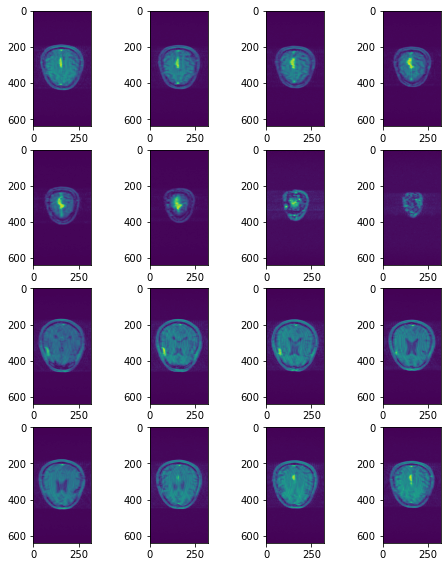

In [6]:
plt.rcParams['figure.figsize'] = (16, 16)

# # Show zero-filled'kspace (abs(masked_kspace))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(masked_kspace[i, 0, :,:]))

# # Show zero-filled (abs(zero_filled))
plt.figure(figsize=(8,20))
for i in range(kspace.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(np.abs(zero_filled[i, 0, :,:]))

# # Show zero-filled's phase(angle(zero_filled))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.angle(zero_filled[i,0, :,:]))


Reajustement shape

In [7]:
# zero_filled's shape
zero_filled = zero_filled.squeeze(-1)
    # Création d'une nouvelle dimension pour dissocier la partie réel et imaginaire des complex
shape_new = image.shape + (2,)
input = torch.zeros(shape_new)
input[..., 0] = zero_filled.real
input[..., 1] = zero_filled.imag

print("input : ",input.shape)

input :  torch.Size([16, 1, 640, 320, 2])


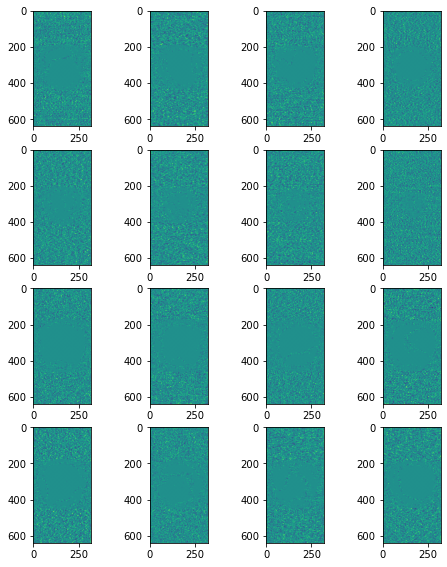

In [28]:
plt.rcParams['figure.figsize'] = (16, 16)

# # Show zero-filled'kspace (abs(masked_kspace))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(masked_kspace[i, 0, :,:]))

# # Show zero-filled (abs(zero_filled))
# plt.figure(figsize=(8,20))
# for i in range(kspace.shape[0]):
#     plt.subplot(8,4,i+1)
#     plt.imshow(np.abs(input[i, 0, :,:, 0]))

# # Show zero-filled's phase(angle(zero_filled))
plt.figure(figsize=(8,20))
for i in range(kspace.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(np.angle(input[i,0, :,:, 1]))


# Varnet model

In [38]:
# Parametre
chans = 32
center_fractions = [0.08]
accelerations = [4]
mask_center = True
lr = 0.0001

# Model
varnet = VarNet(
    num_cascades=2,
    sens_chans=4,
    sens_pools=2,
    chans=chans,
    pools=2,
    mask_center=mask_center,
)

# Loss
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(varnet.parameters(), lr=lr)
loss_list = []

# Train
num_epochs = 1
for epoch in range(num_epochs):
    # input = Variable(input)
    # target = Variable(target)

    optimizer.zero_grad()

    outputs = varnet(input, mask.byte())
    
    loss = criterion(outputs, target)
    loss_list.append(loss.item())

    loss.backward()
    optimizer.step()

    # print(f'Epoch [{epoch+1}/{num_epochs}]')

torch.save(varnet.state_dict(), 'fastmri_varnet_model.pth')

/home/lo276838/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1, 1, 640, 320])) that is different to the input size (torch.Size([16, 640, 320])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


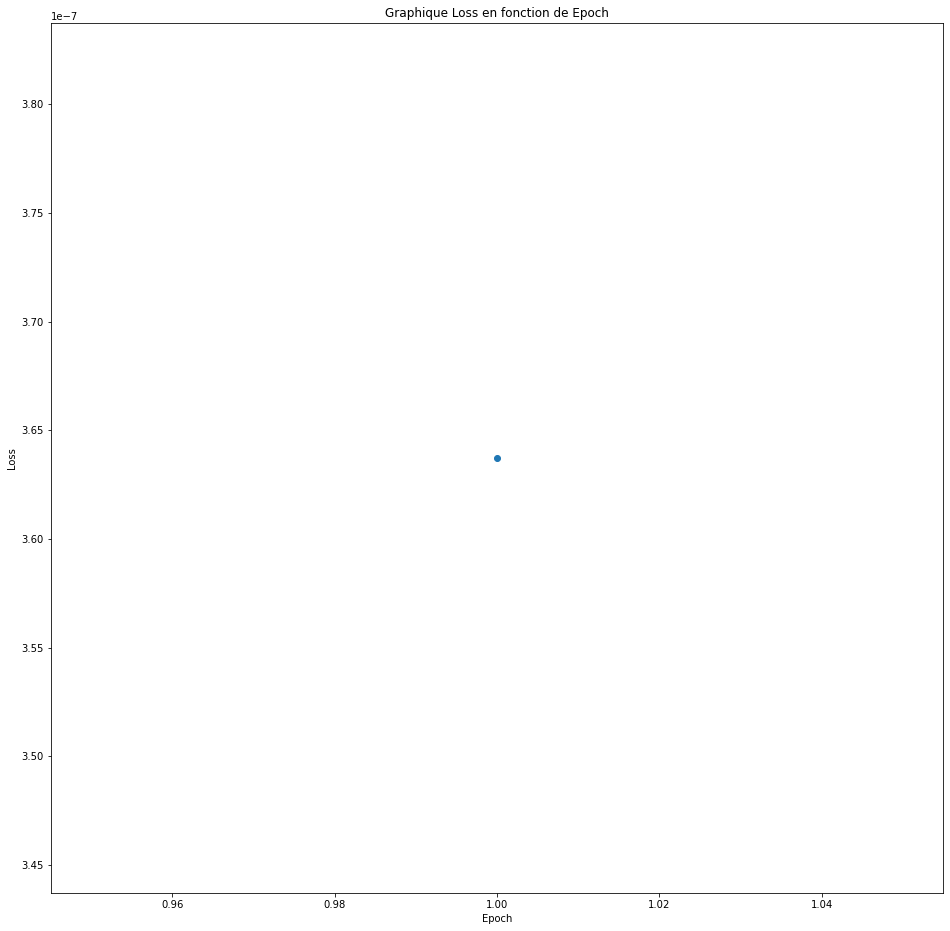

In [11]:
indices = list(range(1, len(loss_list) + 1))

plt.plot(indices, loss_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Graphique Loss en fonction de Epoch')
plt.show()


# Test the model 

In [12]:
model = VarNet(
    num_cascades=2,
    sens_chans=4,
    sens_pools=2,
    chans=chans,
    pools=2,
    mask_center=mask_center,
)
model.load_state_dict(torch.load('fastmri_varnet_model.pth'))

file_path_T = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"
kspace_multicoil_T = load_and_transform(file_path_T)
images_multicoil_T = torch.fft.fftshift(torch.fft.ifft2(kspace_multicoil_T))
image_T = virtual_coil_reconstruction(images_multicoil_T)
image_T = image_T.unsqueeze(1)
kspace_T = torch.fft.fft2(image_T)

mask_func_T = create_mask_for_mask_type(mask_type, center_fractions, accelerations)
kspace_T = kspace_T.unsqueeze(-1)

zero_filled_list, mask_list = [], []
for batch in range (kspace_T.shape[0]) :
    mask_T, _ = mask_func_T(kspace_T.shape)
    masked_kspace_T = kspace_T[batch] * mask_T
    zero_filled_T =torch.fft.ifftn(masked_kspace_T)
    zero_filled_list.append(zero_filled_T)
    mask_list.append(mask_T)

zero_filled_T = torch.cat(zero_filled_list)
mask_T = torch.cat(mask_list)

zero_filled_T = zero_filled_T.squeeze(-1)
shape_new = image_T.shape + (2,)
input_T = torch.zeros(shape_new)
input_T[..., 0] = zero_filled_T.real
input_T[..., 1] = zero_filled_T.imag 

test_image = input_T

model.eval()
with torch.no_grad():
    predicted_images = model(test_image, mask_T.byte())
model.train()


VarNet(
  (sens_net): SensitivityModel(
    (norm_unet): NormUnet(
      (unet): Unet(
        (down_sample_layers): ModuleList(
          (0): ConvBlock(
            (layers): Sequential(
              (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (2): LeakyReLU(negative_slope=0.2, inplace=True)
              (3): Dropout2d(p=0.0, inplace=False)
              (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (5): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (6): LeakyReLU(negative_slope=0.2, inplace=True)
              (7): Dropout2d(p=0.0, inplace=False)
            )
          )
          (1): ConvBlock(
            (layers): Sequential(
              (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

In [48]:
predicted_images = torch.fft.ifftshift(predicted_images)

TypeError: Image data of dtype complex64 cannot be converted to float

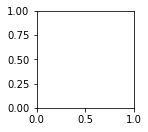

In [49]:
# # Show zero-filled (abs(zero_filled))
plt.figure(figsize=(8,20))
for i in range(kspace.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(torch.fft.ifftn(predicted_images[i]).detach().numpy())

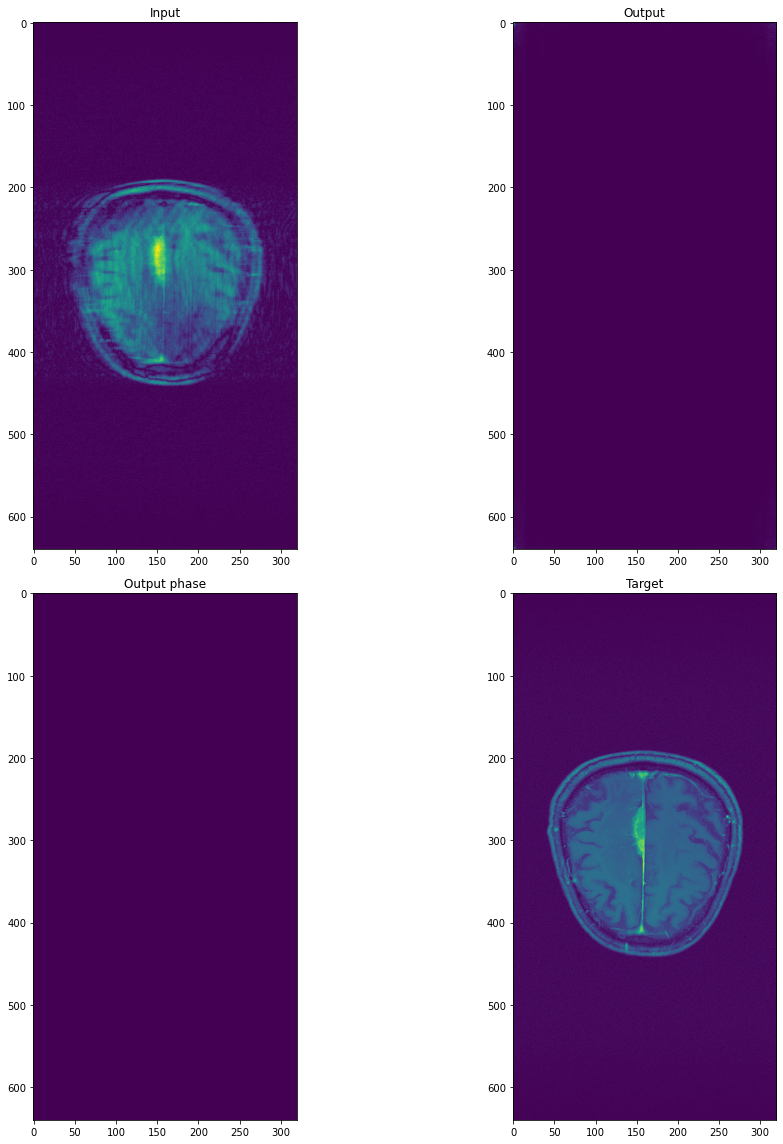

In [14]:
plt.subplot(2,2,1)
plt.imshow(np.abs(test_image[0, 0, :, :, 0 ]))
plt.title("Input")

plt.subplot(2,2,2)
plt.imshow(predicted_images[0])
plt.title("Output")

plt.subplot(2,2,3)
plt.imshow(np.angle(predicted_images[0, :,: ]))
plt.title("Output phase")

plt.subplot(2,2,4)
plt.imshow(np.abs(image[0, 0, :,: ]))
plt.title("Target")

plt.tight_layout()
plt.show()